# Week 26 | 25th June - 1st July 2018

In [1]:
#packages
import pandas as pd
import csv
import matplotlib as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import glob
import pycountry
from datetime import datetime

#chaning the number of columns that are displayed. get will tell you how much. 
pd.set_option("display.max_columns",50)
sns.set_style("whitegrid")

#currency converter
from currency_converter import CurrencyConverter
c = CurrencyConverter('http://www.ecb.int/stats/eurofxref/eurofxref-hist.zip')

pd.options.mode.chained_assignment = None

# 1. Performance per Country

In [2]:
### Cleaning

#importing Data
df_campaign=pd.read_excel("26_campaign.xlsx")

#dropping unused columns
df_campaign.drop(columns=["id","status","Rejection rate","url","client_id","ap_campaign_id",
                          "ad_set_campaign_group_id","notification_stop_spend_threshold","margin_percentage",
                          "facebook_business_id","contract_range","salesforce_oppurtunity_id"], inplace=True)

#1. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_campaign["marginP"] = df_campaign.apply(woo, axis=1)
df_campaign["marginP"] = df_campaign["marginP"].round(2)

#2. COUNTRY NAMES
df_campaign["country"]=df_campaign["iso_code"].str.split("_").str[1]
def get_country_code(x):
    return pycountry.countries.get(alpha_2=x).name
df_campaign["country"] = df_campaign["country"].apply(get_country_code)
df_campaign.drop(columns=["iso_code"], inplace=True)

### 1.1 Average Margin % per country

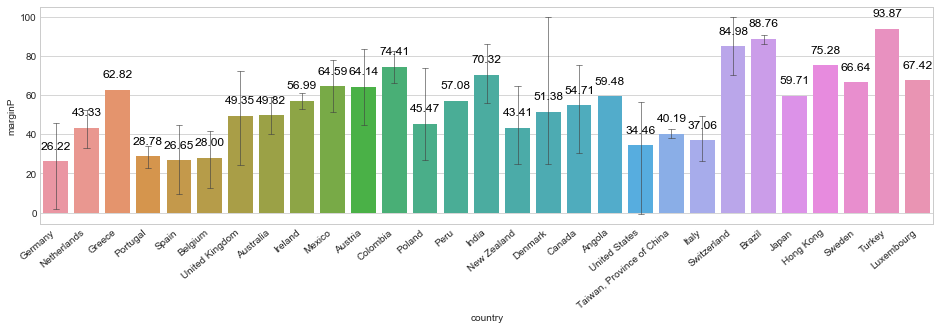

In [3]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="country", y="marginP", data=df_campaign, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

In [4]:
def converter(x):
    if x["business_name"] == "Toronto":
        return(c.convert(x["margin"], "CAD", "EUR"))
    if x["business_name"] == "Melbourne":
        return(c.convert(x["margin"], "AUD", "EUR"))
    if x["business_name"] == "London":
        return(c.convert(x["margin"], "GBP", "EUR"))
    else:
        return(x["margin"])

df_campaign=df_campaign.assign(**{"converted": df_campaign.apply(converter, axis=1)})

df_campaign["converted"]=df_campaign["converted"].round(2)

In [5]:
#total by country
df_campaign['total']=1
df_country=df_campaign.groupby(by=['country']).sum()
df_country["margin_%"]=(df_country["margin"]/df_country["revenue"])*100
df_country["margin_%"]=df_country["margin_%"].round(2)
df_country["country"]=df_country.index

### 1.2 Total Margin % per country

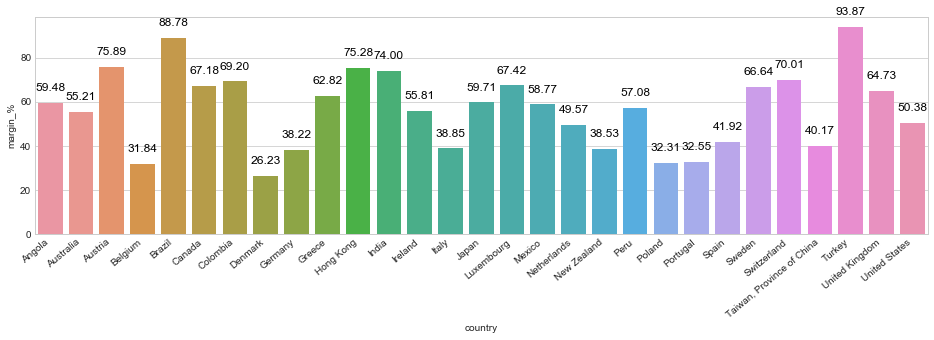

In [6]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="country", y="margin_%", data=df_country, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

### 1.3 Margin across countries in native currency

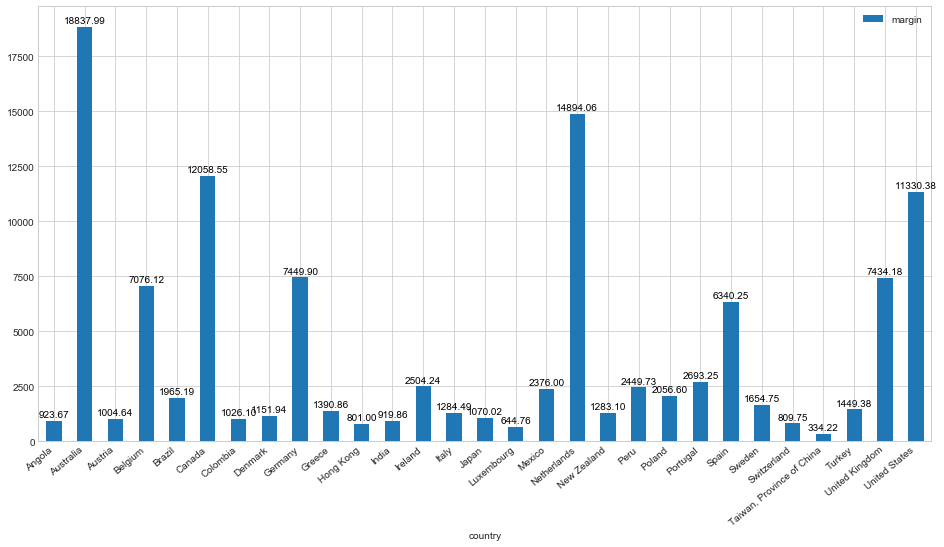

In [7]:
pa=df_country[["margin"]].plot(kind="bar", figsize=(16,8))
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=10, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 1.4 Margins in Euro

#### *This currecy conversion should be updated relatively regularly. I have tested it a few times and it is very accurite with smaller amounts and within €5 (+/-) for larger amounts (e.g. 2606.53 CAD was converted to 1701.50 EUR, when it should be 1,696.17 EUR)*

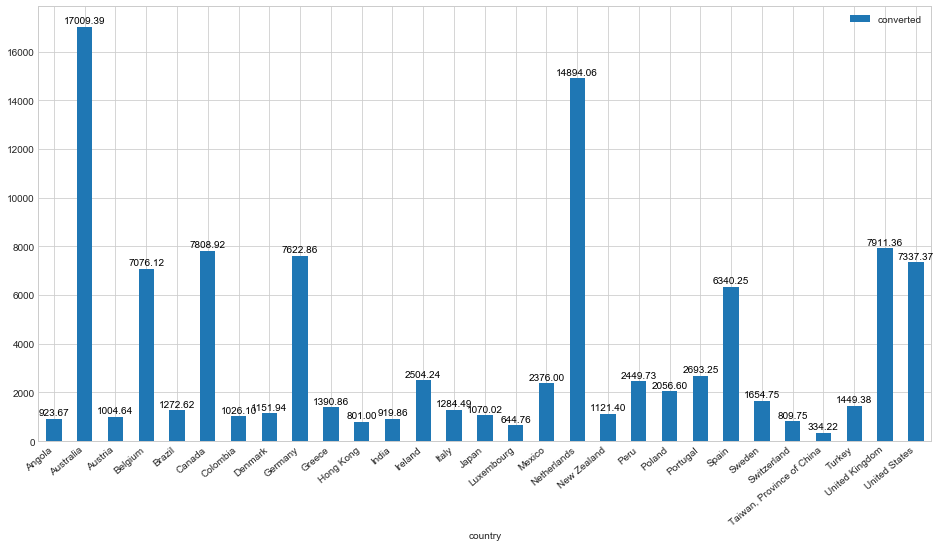

In [8]:
pa=df_country[["converted"]].plot(kind="bar", figsize=(16,8))
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=10, color="black", xytext=(0, 6),
                 textcoords="offset points")

______

# 2. Performance per Marketer

### 2.1 Margin % of marketer's campaigns 

#### Onno

##### *Best*

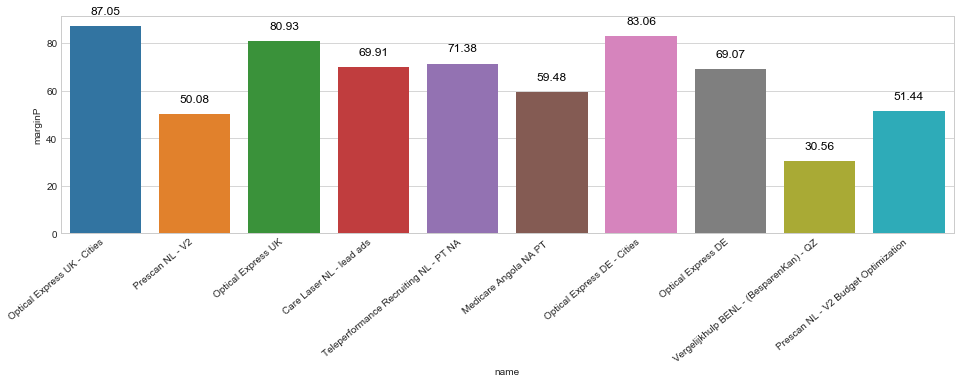

In [9]:
df_onno=df_campaign.loc[df_campaign["marketer_name"]=="Onno Bossen"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_onno.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### *Worst* 

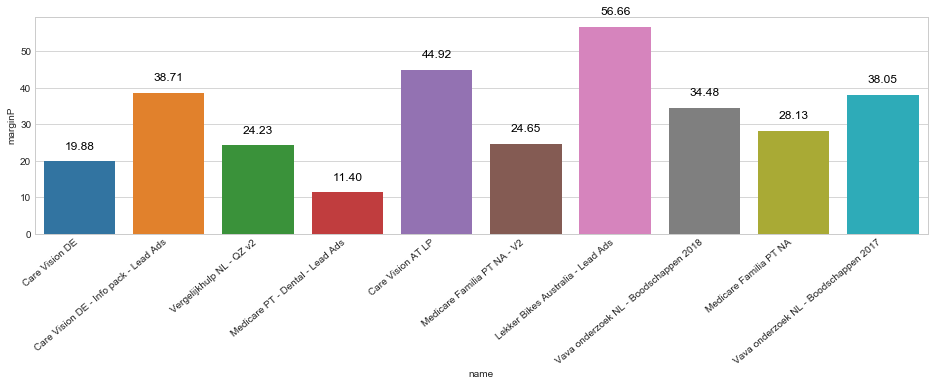

In [10]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_onno.loc[df_onno["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Marleen

##### *Best*

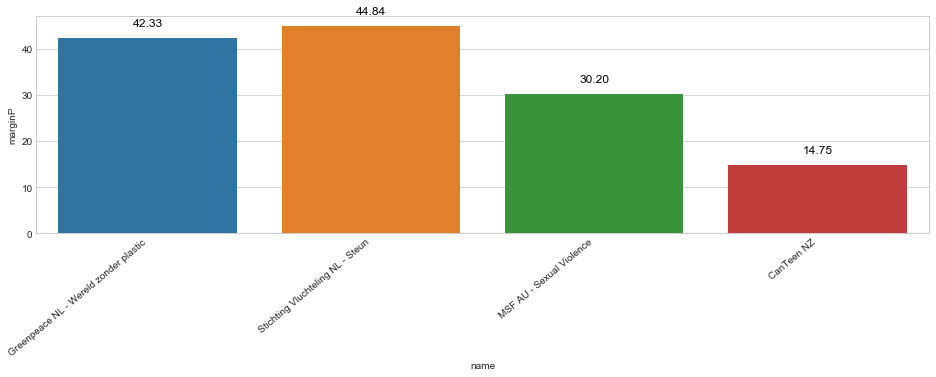

In [11]:
df_marleen=df_campaign.loc[df_campaign["marketer_name"]=="Marleen Blokker"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_marleen.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

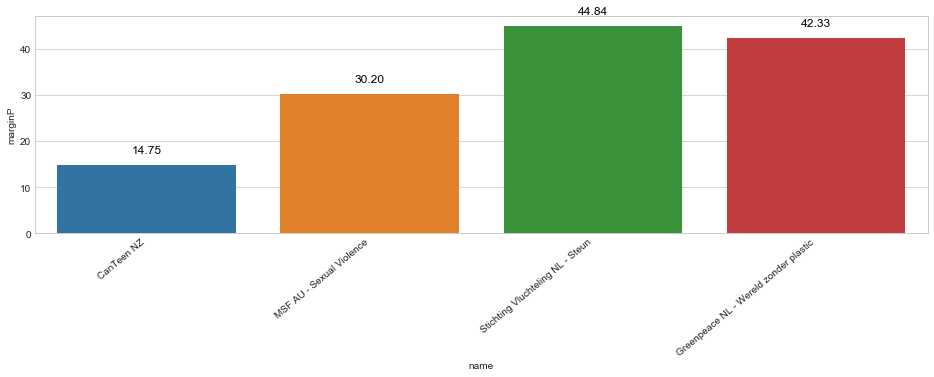

In [12]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_marleen.loc[df_marleen["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Robin

##### *Best*

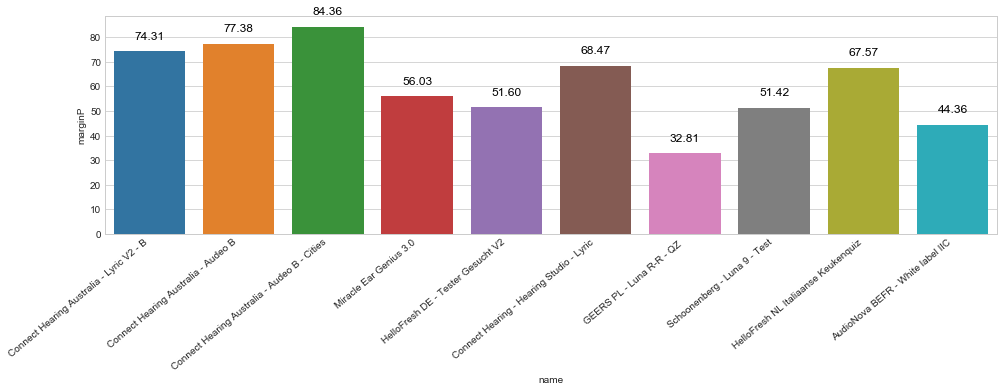

In [13]:
df_robin=df_campaign.loc[df_campaign["marketer_name"]=="Robin Ten Hove"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_robin.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

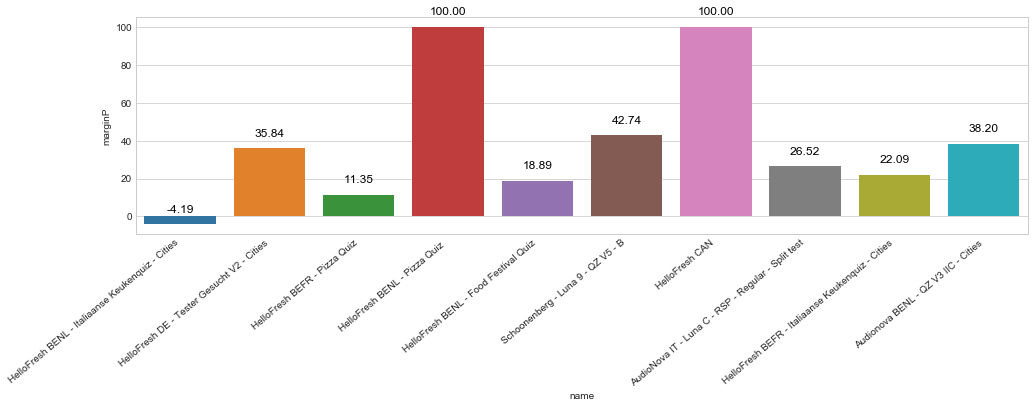

In [14]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_robin.loc[df_robin["leads"]>4].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Jeanine

##### *Best*

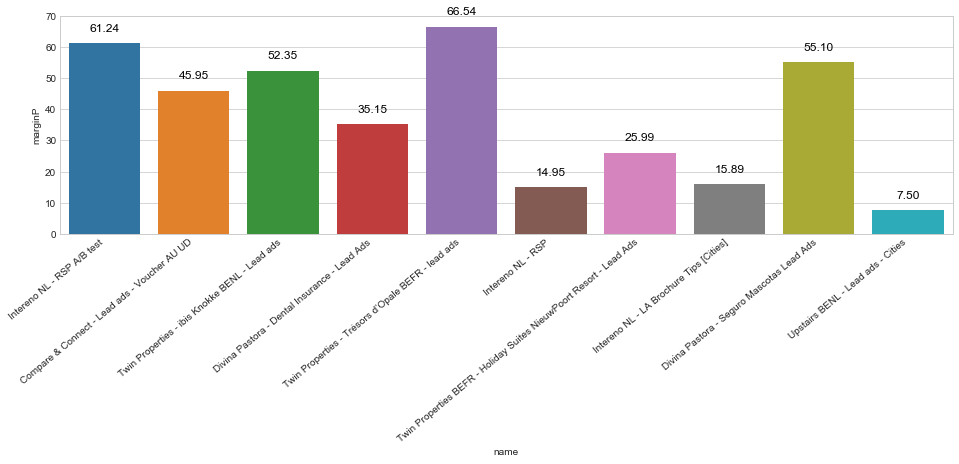

In [15]:
df_jeanine=df_campaign.loc[df_campaign["marketer_name"]=="Jeanine de Konnigh"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_jeanine.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

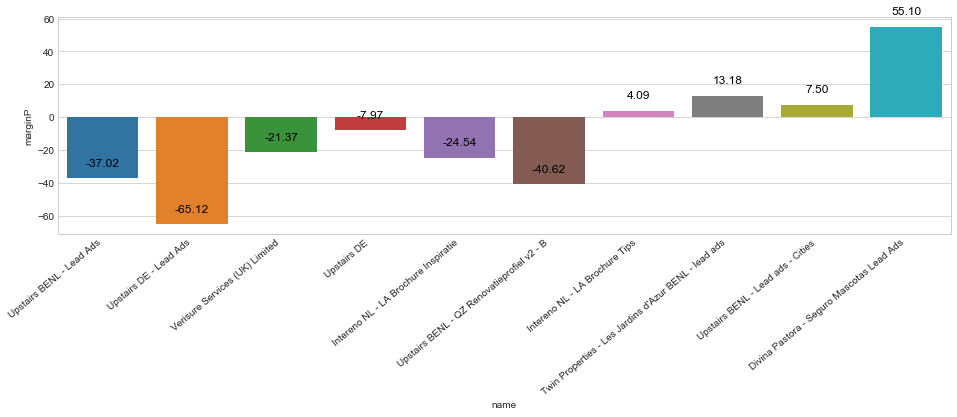

In [16]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_jeanine.loc[df_jeanine["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Daniela

##### *Best*

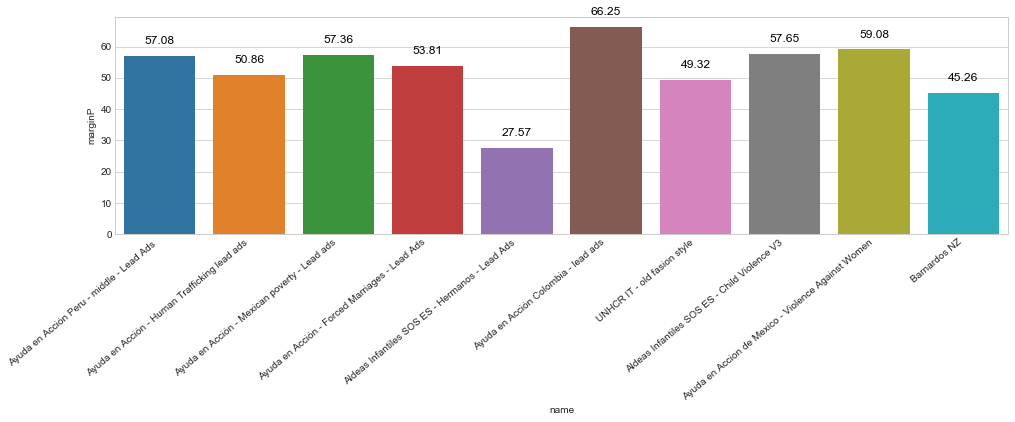

In [17]:
df_daniela=df_campaign.loc[df_campaign["marketer_name"]=="Daniela Jacobo Gallardo"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_daniela.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

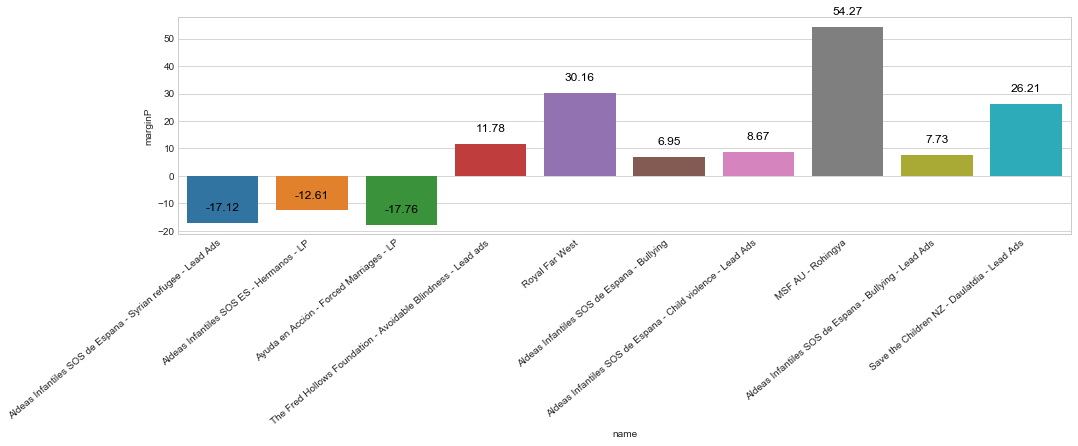

In [18]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_daniela.loc[df_daniela["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Rob

##### *Best*

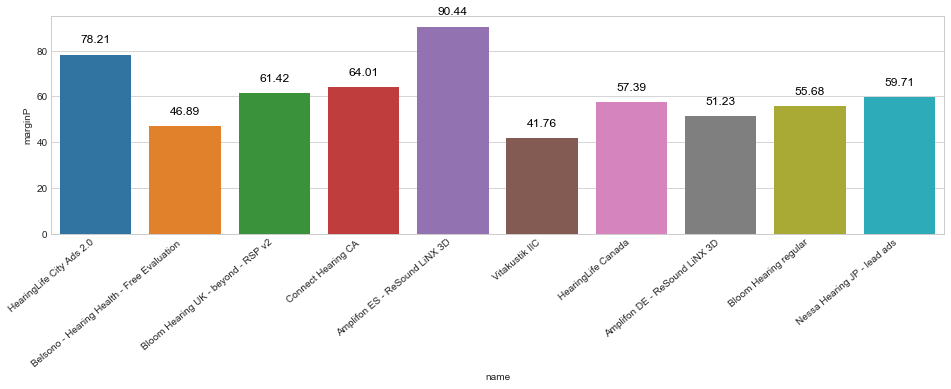

In [19]:
df_rob=df_campaign.loc[df_campaign["marketer_name"]=="Rob Ransome"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_rob.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

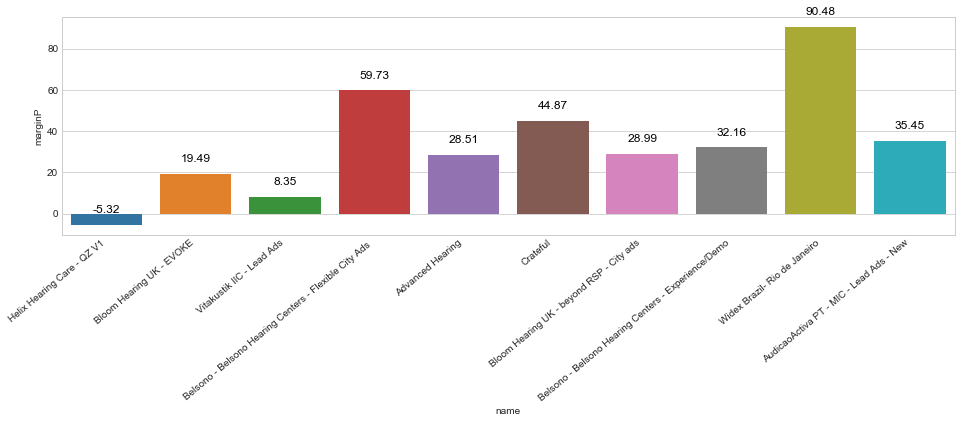

In [20]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_rob.loc[df_rob["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

#### Sam

##### *Best*

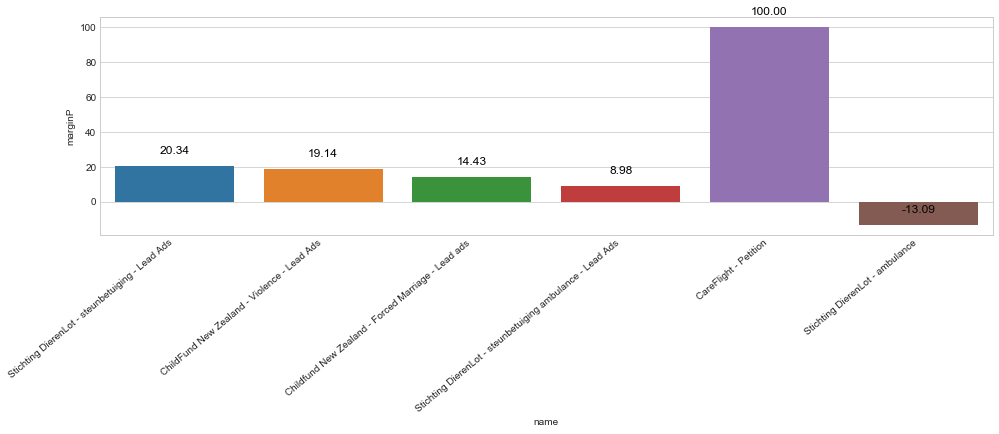

In [21]:
df_sam=df_campaign.loc[df_campaign["marketer_name"]=="Sam Drentje"]
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_sam.nlargest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### *Worst*

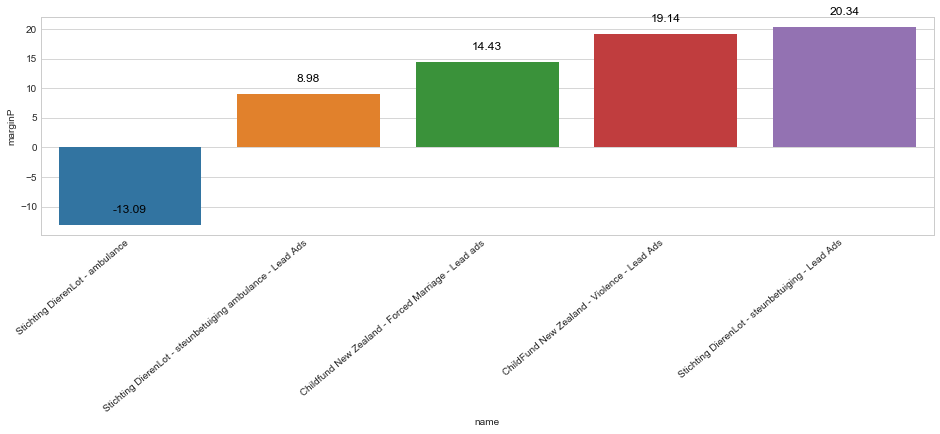

In [22]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="name", y="marginP", data=df_sam.loc[df_sam["leads"]>2].nsmallest(10,'converted'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

In [23]:
#total by marketer
df_marketer=df_campaign.groupby(by=['marketer_name']).sum()

### 2.2 Margin made per Marketer (in Euro)

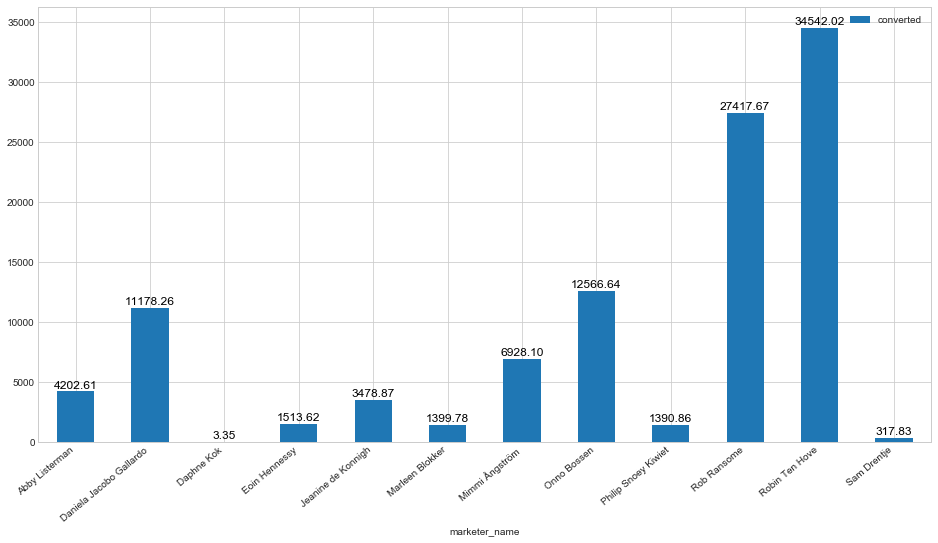

In [24]:
pa=df_marketer[["converted"]].plot(kind="bar", figsize=(16,8))
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 2.3 Average margin per marketer

In [25]:
#creating new variable
df_marketer["average"]=df_marketer["converted"]/df_marketer["total"]

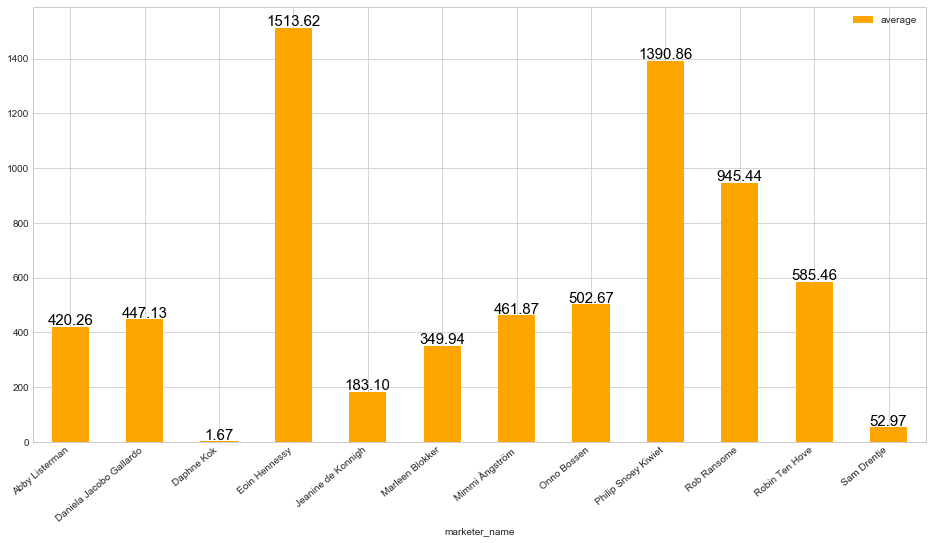

In [26]:
pa=df_marketer[["average"]].plot(kind="bar", figsize=(16,8), color="orange")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 2.4 Average margin % per marketer

In [27]:
#creating new variable
df_marketer["average_%"]=df_marketer["marginP"]/df_marketer["total"]

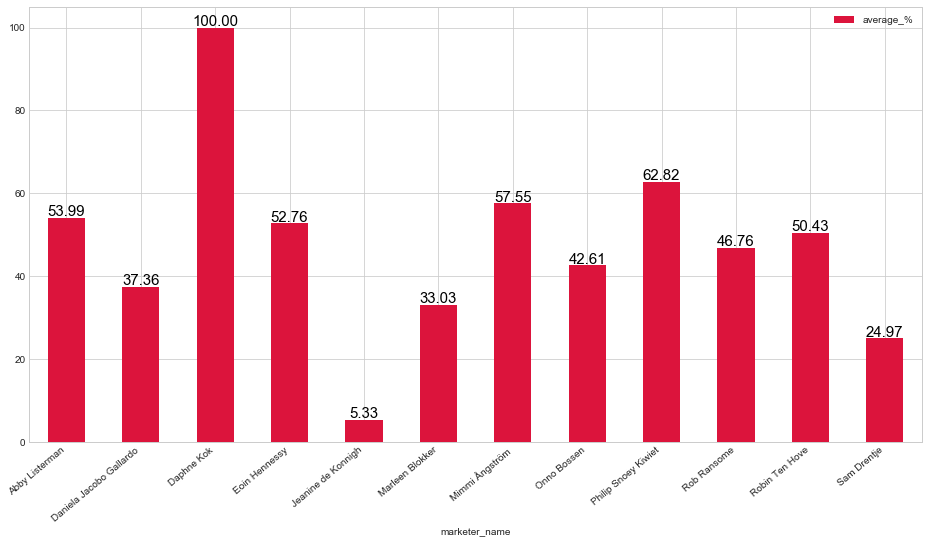

In [28]:
pa=df_marketer[["average_%"]].plot(kind="bar", figsize=(16,8), color="crimson")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

________

# 3. Performance per Vertical

In [29]:
def yoo(x):
    if x["marketer_name"]=="Onno Bossen" or x["marketer_name"]=="Jeanine de Konnigh":
        return("other?")
    if x["marketer_name"]=="Mimmi Ångström" or x["marketer_name"]=="Abby Listerman" or x["marketer_name"]=="Sam Drentje" or x["marketer_name"]=="Marleen Blokker" or x["marketer_name"]=="Daniela Jacobo Gallardo" or x["marketer_name"]=="Daphne Kok":
        return("NGOs")
    if x["marketer_name"]=="Philip Snoey Kiwiet" or x["marketer_name"]=="Robin Ten Hove" or x["marketer_name"]=="Rob Ransome" or x["marketer_name"]=="Eoin Hennessy":
        return("hearing aids")
df_campaign["vertical"] = df_campaign.apply(yoo, axis=1)

### 3.1 Average Margin % per vertical

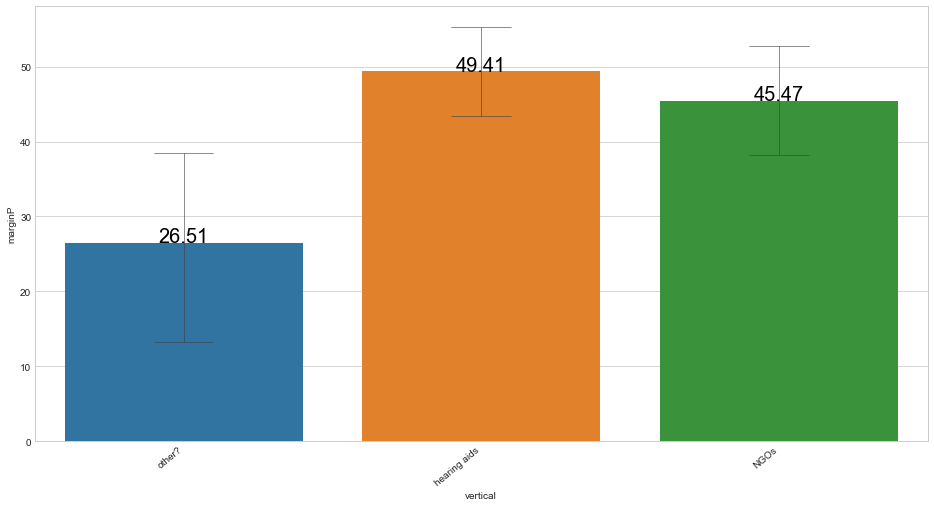

In [30]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="vertical", y="marginP", data=df_campaign, capsize=.2, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 6),
                 textcoords="offset points")

In [31]:
#total by vertical
df_vertical=df_campaign.groupby(by=['vertical']).sum()
df_vertical["margin_%"]=(df_vertical["margin"]/df_vertical["revenue"])*100
df_vertical["margin_%"]=df_vertical["margin_%"].round(2)
df_vertical["Vertical"]=df_vertical.index

### 3.2 Total Margin % per vertical

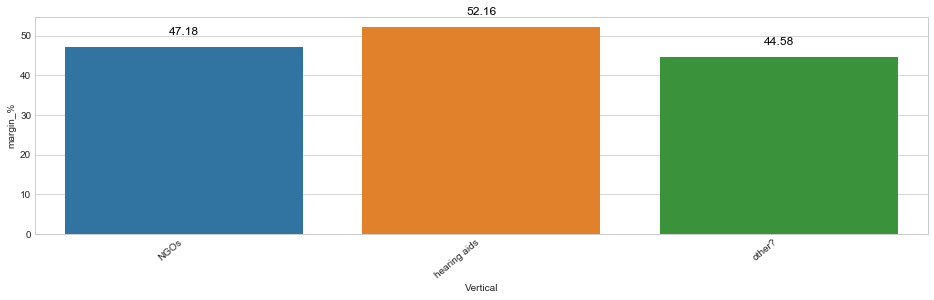

In [32]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="Vertical", y="margin_%", data=df_vertical, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

### 3.3 Total Margin per vertical

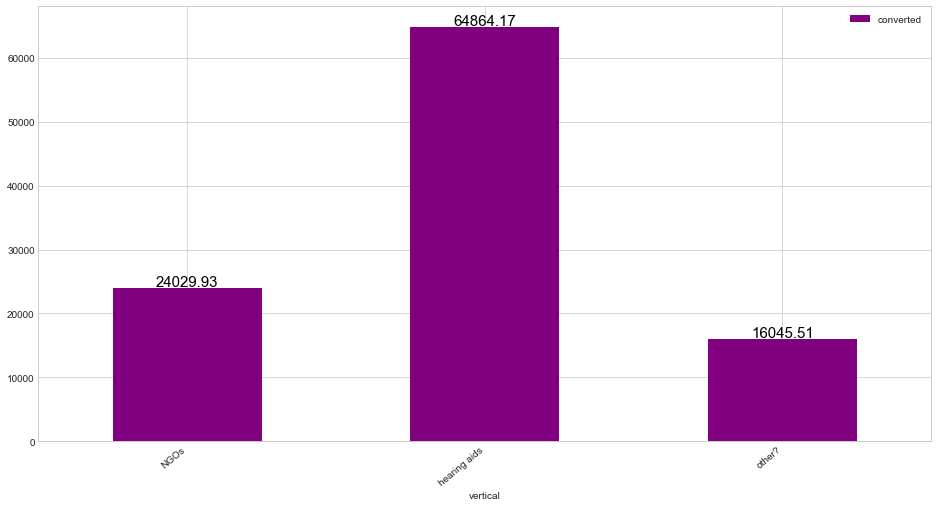

In [33]:
pa=df_vertical[["converted"]].plot(kind="bar", figsize=(16,8), color="purple")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

_______

# 4. Performance per Business

### 4.1 Average Margin % per vertical

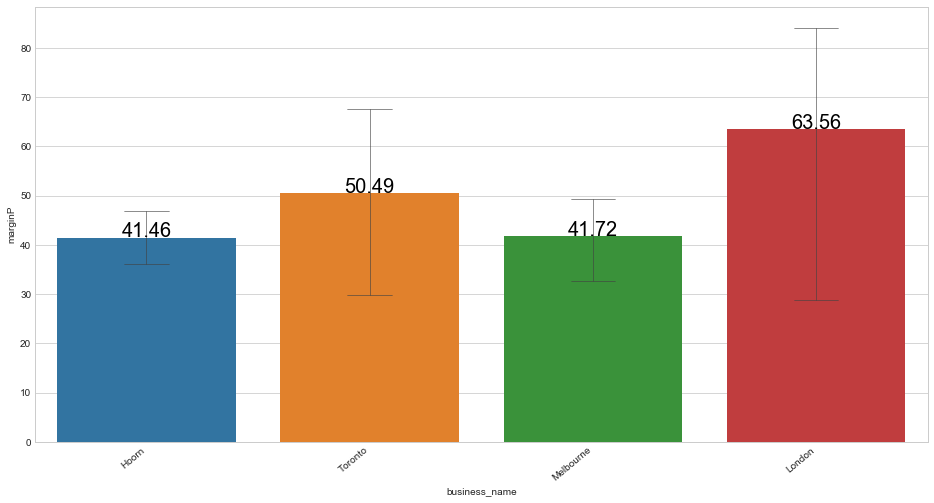

In [34]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="business_name", y="marginP", data=df_campaign, capsize=.2, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 6),
                 textcoords="offset points")

In [35]:
#total by business
df_business=df_campaign.groupby(by=['business_name']).sum()
df_business["margin_%"]=(df_business["margin"]/df_business["revenue"])*100
df_business["margin_%"]=df_business["margin_%"].round(2)
df_business["Business"]=df_business.index

### 4.2 Total Margin % per vertical

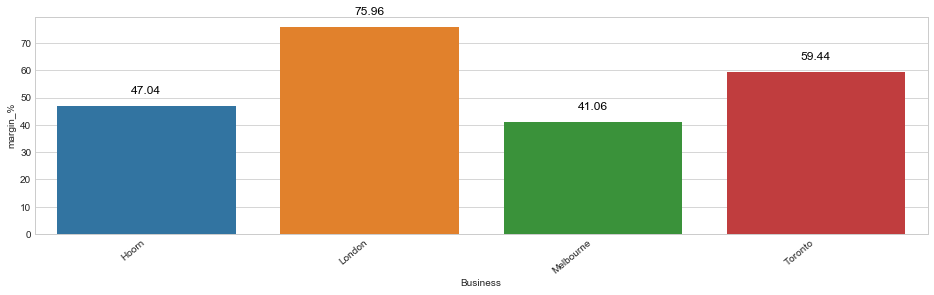

In [36]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="Business", y="margin_%", data=df_business, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

### 4.3 Margin per Business (in Euro)

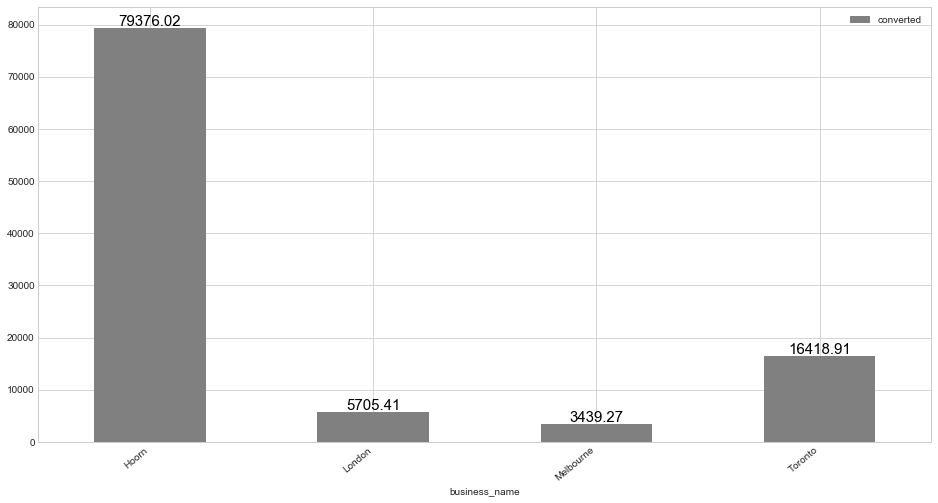

In [37]:
pa=df_business[["converted"]].plot(kind="bar", figsize=(16,8), color="grey")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

___________

# 5. Performance per Day of the Week

CPC, CTR, CPM, CR and CPA are displayed as the average per day

In [38]:
#importing multiple files using glob
#getting bert data
sheetnames=glob.glob("26__*.xlsx")
list_of_dfs = [pd.read_excel(sheet) for sheet in sheetnames]
for dataframe, sheet in zip(list_of_dfs, sheetnames):
    dataframe["day_num"] = sheet
df_daily = pd.concat(list_of_dfs, ignore_index=True) 

In [39]:
### Cleaning

#creating day of the week variable
df_daily["day_num"]=df_daily["day_num"].str.split("_").str[2]
def doo(x):
    if x["day_num"] == "1.xlsx":
        return("monday")
    if x["day_num"] == "2.xlsx":
        return("tuesday")
    if x["day_num"] == "3.xlsx":
        return("wednesday")
    if x["day_num"] == "4.xlsx":
        return("thursday")
    if x["day_num"] == "5.xlsx":
        return("friday")
    if x["day_num"] == "6.xlsx":
        return("saturday")
    else:
        return("sunday")
df_daily["day"] = df_daily.apply(doo, axis=1)

#dropping unused columns
df_daily.drop(columns=["id","status","ad_set_manager_id","client_id","ap_campaign_id","ad_set_campaign_group_id",
                      "notification_stop_spend","notification_stop_spend_threshold","margin_percentage",
                      "facebook_business_id","url","contract_range","salesforce_oppurtunity_id"], inplace=True)

#1. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_daily["marginP"] = df_daily.apply(woo, axis=1)
df_daily["marginP"] = df_daily["marginP"].round(2)

#2. COUNTRY NAMES
df_daily["country"]=df_daily["iso_code"].str.split("_").str[1]
def get_country_code(x):
    return pycountry.countries.get(alpha_2=x).name
df_daily["country"] = df_daily["country"].apply(get_country_code)
df_daily.drop(columns=["iso_code"], inplace=True)

df_daily.drop(columns=["day_num"], inplace=True)

order=["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]

### 5.1 Average Margin % per day of the Week

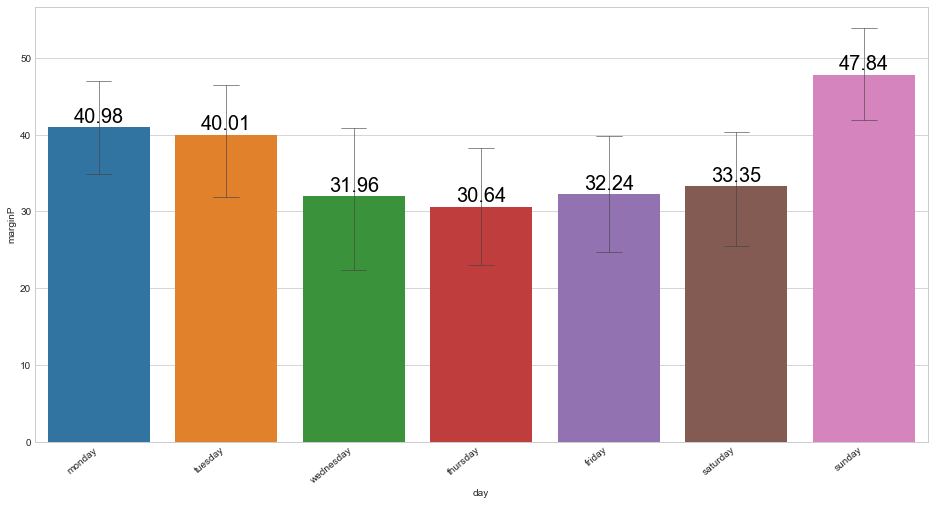

In [40]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="day", y="marginP", data=df_daily, capsize=.2, order=order, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 10),
                 textcoords="offset points")

In [41]:
df_daily=df_daily.assign(**{"converted": df_daily.apply(converter, axis=1)})

df_daily["converted"]=df_daily["converted"].round(2)

In [42]:
#total by vertical
df_daily_group=df_daily.groupby(by=["day"]).sum()
df_daily_group["margin_%"]=(df_daily_group["margin"]/df_daily_group["revenue"])*100
df_daily_group["margin_%"]=df_daily_group["margin_%"].round(2)
df_daily_group["Day"]=df_daily_group.index

### 5.2 Total Margin % per day

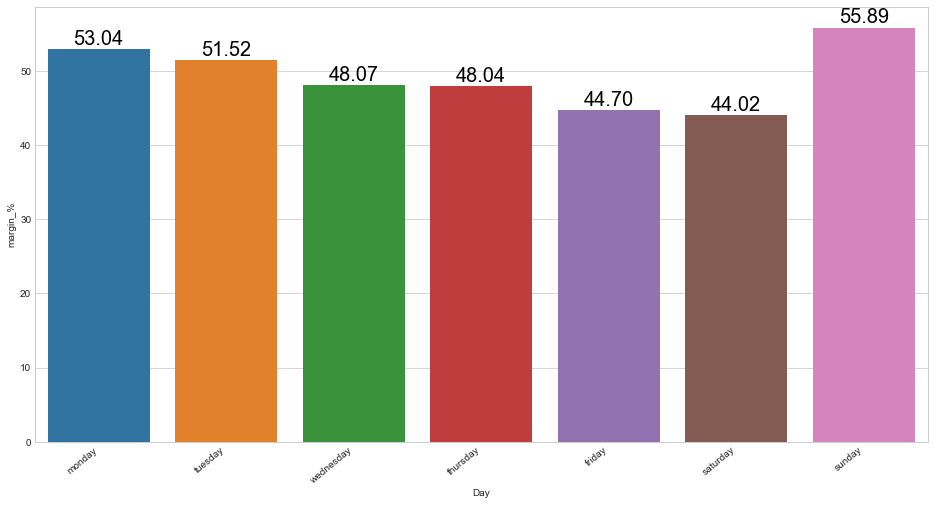

In [43]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="Day", y="margin_%", data=df_daily_group, capsize=.2, order=order, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 10),
                 textcoords="offset points")

### 5.3 Total Margin

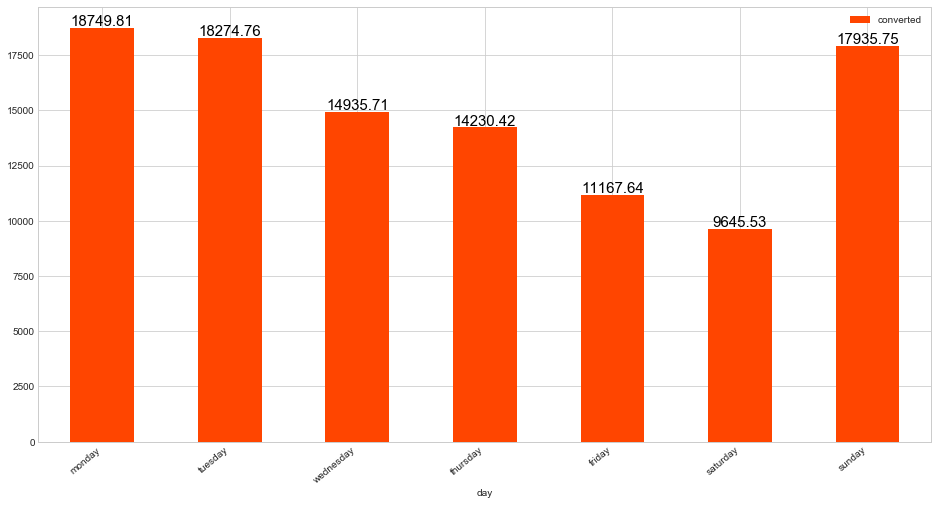

In [44]:
pa=df_daily_group[["converted"]].loc[order].plot(kind="bar", figsize=(16,8), color="orangered")
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=15, color="black", xytext=(0, 6),
                 textcoords="offset points")

### 5.4 CPA

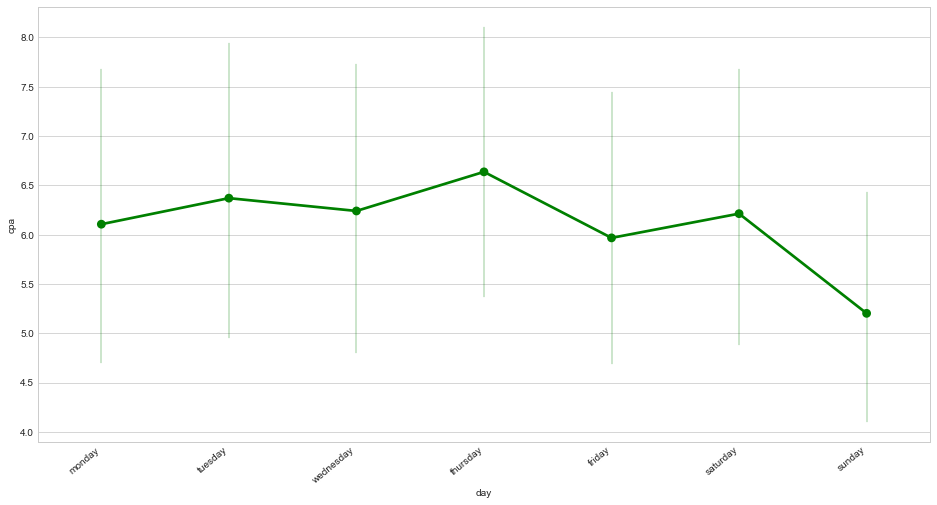

In [45]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpa", data=df_daily, order=order, color="g", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 5.5 CPC

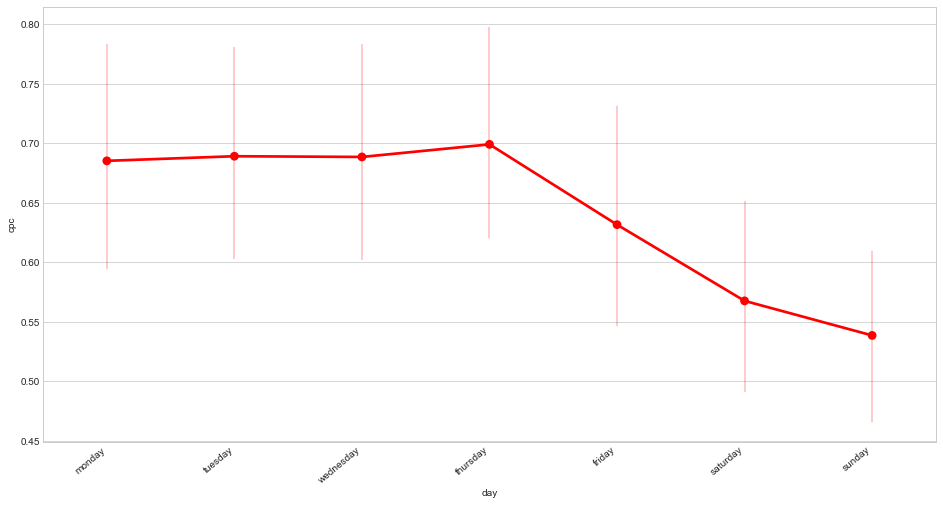

In [46]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpc", data=df_daily, order=order, color="r", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 5.6 CPM

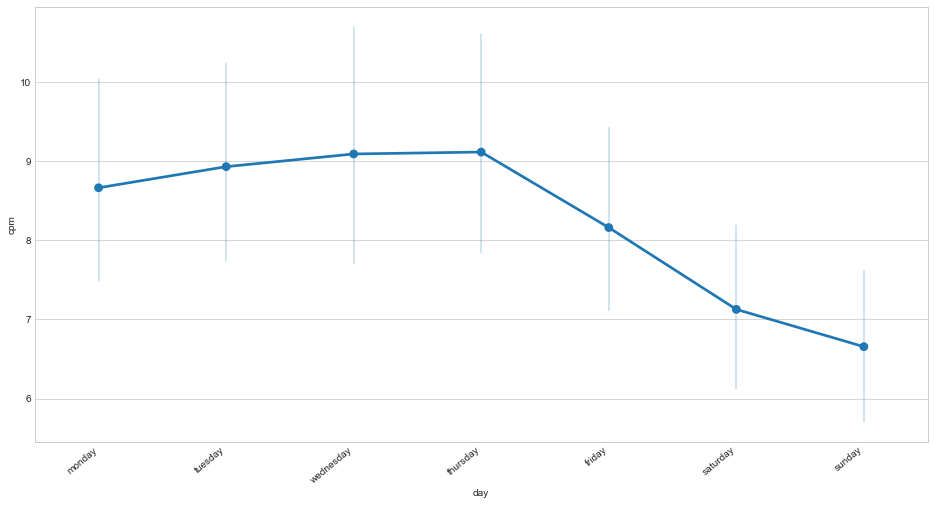

In [47]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpm", data=df_daily, order=order, dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 5.7 CR

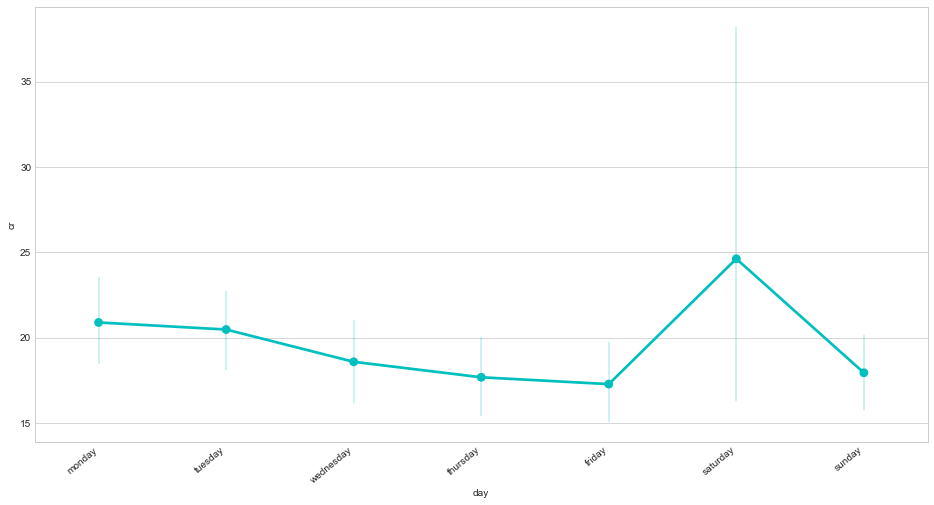

In [48]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cr", data=df_daily, order=order, color="c", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

### 5.8 CTR

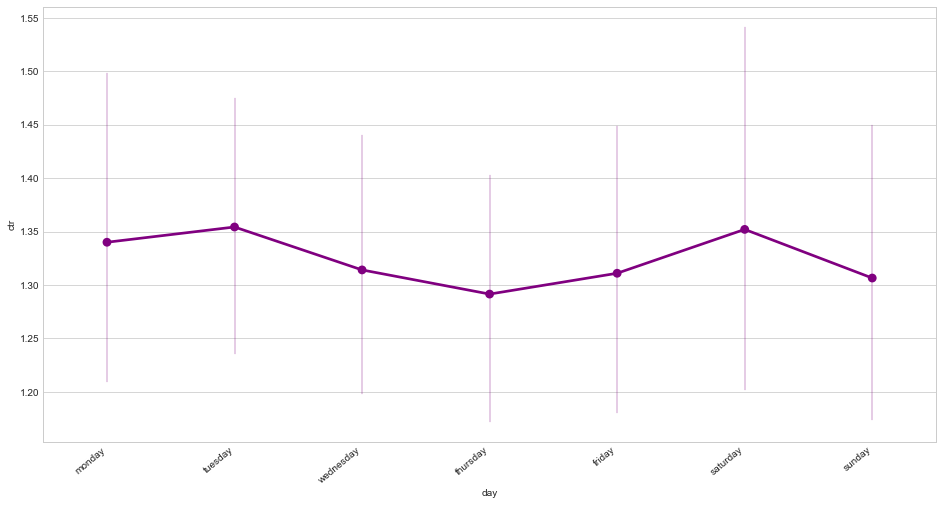

In [49]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="ctr", data=df_daily, order=order, color="purple", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

_______

# 6. Top performing new ads

In [50]:
##### Cleaning

df_raw=pd.read_excel("26_newads.xlsx")

#subsetting data
df_newads=df_raw.loc[df_raw["insert_time"]>=datetime(2018,6,11)]

#dropping columns
df_newads.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                       "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                       "short_url","ad_url_domain_id"], inplace=True)

#1. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_newads["marginP"] = df_newads.apply(woo, axis=1)
df_newads["marginP"] = df_newads["marginP"].round(2)



The table below shows new ads that had a margin % above 50%. They are displayed in descending order from highest margin to lowest (this will filter out ads with 100% margins that made very little money). 



In [51]:
df_newads.loc[df_newads['marginP']>=50].nlargest(10,'margin').drop(columns=["name","relevance_score","insert_time",
                                                                            "revenue_type","frequency"])

,tag,campaign_name,marketer_name,campaign_manager_name,account_manager_name,budget,leads,revenue,purchase,margin,ctr,cpc,cpm,cr,cpa,update_time,currency,marginP,views,clicks
1423,SB000000001154201,Connect Hearing CA,Rob Ransome,Daniela Salom Cardenas,Sen Nathan,120.0,58,1948.80,520.98,1427.82,1.3,1.4,17.2,15.3,9.0,2018-07-02 10:01:42,CAD,73.27,30374,380
1230,SB000000001155542,Bloom Hearing UK - beyond - RSP v2,Rob Ransome,Marisa Jimenez,Sander Janssen,100.0,51,1331.10,342.68,988.42,1.2,1.0,11.4,14.7,6.7,2018-07-02 04:03:19,EUR,74.26,30061,348
1482,SB000000001155953,Optical Express UK,Onno Bossen,Aedan Toal,Matt Butcher,30.0,67,911.20,155.14,756.06,0.9,0.5,4.2,20.4,2.3,2018-07-02 02:00:25,GBP,82.97,37371,329
1616,SB000000001159115,Intereno NL - RSP A/B test,Jeanine de Konnigh,Jordy Schreuder,Sander Janssen,125.0,52,962.00,338.19,623.81,1.7,0.3,5.8,5.2,6.5,2018-07-02 01:00:24,EUR,64.85,58753,1000
1504,SB000000001156616,UNHCR Australia,Abby Listerman,Tom Wells,Bart Kramer,60.0,248,1004.63,409.88,594.75,1.9,0.6,11.8,37.2,1.7,2018-07-01 17:01:04,AUD,59.20,34830,666
1617,SB000000001159118,Intereno NL - RSP A/B test,Jeanine de Konnigh,Jordy Schreuder,Sander Janssen,125.0,50,925.00,348.55,576.45,1.5,0.4,5.8,5.5,7.0,2018-07-02 01:00:28,EUR,62.32,59798,910
1764,SB000000001160039,GEERS PL - Luna R-R - QZ - Split test,Robin Ten Hove,Marisa Jimenez,Bart Kramer,20.0,73,700.80,130.43,570.37,0.8,0.3,2.9,19.0,1.8,2018-07-02 01:09:35,EUR,81.39,45200,384
1228,SB000000001155536,Bloom Hearing UK - beyond - RSP v2,Rob Ransome,Marisa Jimenez,Sander Janssen,100.0,35,913.50,350.28,563.22,1.1,1.0,10.5,9.6,10.0,2018-07-02 04:03:15,EUR,61.66,33248,364
1481,SB000000001155944,Optical Express UK,Onno Bossen,Aedan Toal,Matt Butcher,30.0,52,707.20,153.53,553.67,0.7,0.6,4.1,19.9,3.0,2018-07-02 02:00:21,GBP,78.29,37463,261
1248,SB000000001155767,HelloFresh BENL - Kookenquête Nespresso,Robin Ten Hove,Eveline Morlang,Bart Kramer,50.0,442,994.50,441.82,552.68,0.9,0.3,2.6,27.5,1.0,2018-07-02 01:15:10,EUR,55.57,172028,1607


.


e.g. this shows the top 10 margin (percentage) ads that had margins of over €150, ordered from highest conversion rate to lowest conversion rate.


In [52]:
df_newads.loc[df_newads['margin']>=150].nlargest(10,'marginP').sort_values(by='cr', ascending=False).drop(columns=["name","relevance_score","insert_time",
                                                                            "revenue_type","frequency"])

,tag,campaign_name,marketer_name,campaign_manager_name,account_manager_name,budget,leads,revenue,purchase,margin,ctr,cpc,cpm,cr,cpa,update_time,currency,marginP,views,clicks
1370,SB000000001157744,UNICEF Turkish National Committee - Yemen - Le...,Mimmi Ångström,Aedan Toal,Othman Namri,3.0,296,296.0,10.93,285.07,1.4,0.0,0.2,41.6,0.0,2018-07-02 09:35:42,EUR,96.31,49845,711
1364,SB000000001157723,UNICEF Turkish National Committee - Yemen - Le...,Mimmi Ångström,Aedan Toal,Othman Namri,3.0,215,215.0,10.95,204.05,1.5,0.0,0.3,38.5,0.1,2018-07-02 09:35:18,EUR,94.91,37360,558
1362,SB000000001157717,UNICEF Turkish National Committee - Yemen - Le...,Mimmi Ångström,Aedan Toal,Othman Namri,3.0,211,211.0,9.58,201.42,1.6,0.0,0.3,37.3,0.0,2018-07-02 09:35:10,EUR,95.46,35412,565
1372,SB000000001157768,UNICEF Turkish National Committee - Yemen - Le...,Mimmi Ångström,Aedan Toal,Othman Namri,3.0,227,227.0,11.25,215.75,1.5,0.0,0.3,36.1,0.0,2018-07-02 09:35:46,EUR,95.04,41224,628
1860,SB000000001158635,Optical Express DE - Cities,Onno Bossen,Aedan Toal,Matt Butcher,5.0,16,217.6,17.52,200.08,2.8,0.3,6.9,22.9,1.1,2018-07-02 10:39:36,GBP,91.95,2527,70
1818,SB000000001158755,Widex Brazil- Rio de Janeiro,Rob Ransome,Joanna Elliott,Sander Janssen,20.0,16,281.6,26.15,255.45,2.3,0.3,7.7,20.3,1.6,2018-06-30 06:02:30,CAD,90.71,3399,79
1821,SB000000001158770,Widex Brazil- Rio de Janeiro,Rob Ransome,Joanna Elliott,Sander Janssen,25.0,13,228.8,13.41,215.39,3.5,0.2,6.2,17.1,1.0,2018-06-30 06:02:42,CAD,94.14,2174,76
1815,SB000000001158737,Widex Brazil- Sao Paulo,Rob Ransome,Joanna Elliott,Sander Janssen,25.0,12,211.2,16.17,195.03,3.5,0.2,7.6,16.0,1.3,2018-07-01 06:02:03,CAD,92.34,2137,75
1814,SB000000001158725,Widex Brazil- Sao Paulo,Rob Ransome,Joanna Elliott,Sander Janssen,25.0,13,228.8,14.16,214.64,3.3,0.2,5.5,15.3,1.1,2018-07-01 06:01:58,CAD,93.81,2577,85
1261,SB000000001156169,SOS Children's Villages India - Lead Ads,Mimmi Ångström,Marisa Jimenez,Sander Janssen,8.0,169,215.5,0.00,215.50,0.0,0.0,0.0,0.0,0.0,2018-06-29 16:04:06,EUR,100.00,0,0


______________

# 7. Campaigns that are dropping in margin from 45% + to below 45%

In [53]:
#importing new dataset
df_comp_raw=pd.read_excel("25_newads.xlsx")


####FOR WEEK BEFORE DF####


#dropping columns
df_comp_raw.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                          "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                          "short_url","ad_url_domain_id"], inplace=True)


#1. FIX MARGIN_P
df_comp_raw["marginP"] = df_comp_raw.apply(woo, axis=1)
df_comp_raw["marginP"] = df_comp_raw["marginP"].round(2)



####FOR FULL RAW WEEK#####


#dropping columns
df_raw.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                     "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                     "short_url","ad_url_domain_id"], inplace=True)


#1. FIX MARGIN_P
df_raw["marginP"] = df_raw.apply(woo, axis=1)
df_raw["marginP"] = df_raw["marginP"].round(2)


#####SLIMMING COMB DATA DOWN TO ONLY INCLUDE MARGINS ABOVE 45%###########
df_comp=df_comp_raw.loc[df_comp_raw["marginP"]>=45]

####COMBING DATA SETS########
df_452=df_comp.merge(df_raw, how ="inner", on = ["tag"])

df_45=df_452.loc[df_452["marginP_y"]<45]

The number of ads that dropped below 45%: 

In [54]:
len(df_45)

251

In [55]:
#making difference variable
df_45["diff_mP"]=df_45["marginP_x"]-(df_45["marginP_y"])
df_45["diff_m"]=df_45["margin_x"]-(df_45["margin_y"])

In [56]:
#ordering df for simple comparisons
df_45vis = df_45[["tag","campaign_name_x","name_x","diff_mP","diff_m","marginP_x","marginP_y","margin_x","margin_y","ctr_x",
                  "ctr_y","cpm_x","cpm_y","cr_x","cr_y","cpa_x","cpa_y"]]

These are the 10 ads that lost the largest amount of money between the two weeks (i.e. Week 25 and Week 26). 
Here we can compare the other variables a bit easier as well.

_x = week 25

_y = week 26

diff_mP = Difference in Margin % between Week 26 and Week 25 .  
diff_m = Difference in Margin between Week 26 and Week 25 .   

In [57]:
df_45vis.nlargest(10,"diff_m")#.sort_values(by='diff_m', ascending=False)

,tag,campaign_name_x,name_x,diff_mP,diff_m,marginP_x,marginP_y,margin_x,margin_y,ctr_x,ctr_y,cpm_x,cpm_y,cr_x,cr_y,cpa_x,cpa_y
241,SB000000001137242,Belsono - Hearing Health USA,T6 I SB April C M/F 50+ M/D,79.52,564.44,54.73,-24.79,527.13,-37.31,2.2,1.6,41.2,46.4,14.0,7.8,13.6,37.6
522,SB000000001150280,Ethiopiaid,T1 I AD M/V 35+ ALL,24.05,508.09,54.91,30.86,561.42,53.33,3.3,3.6,30.0,36.9,42.5,31.3,2.2,3.3
243,SB000000001138013,Belsono - Belsono Hearing Centers V1,T6 V C M/F 50+ ALL,24.90,480.78,55.36,30.46,742.73,261.95,1.9,1.3,43.1,35.6,14.7,11.3,15.4,23.9
140,SB000000001101172,Belsono - Hearing Health USA,T6 I SB Nov1 E M/F 50+ M/D,30.79,390.78,62.14,31.35,617.28,226.50,1.5,1.2,30.0,29.6,17.2,12.1,11.4,20.7
569,SB000000001154669,Miracle Ear Genius 3.0,T10.3 V SB Jun1 F M/F 50+ M/D,27.30,373.20,50.84,23.54,420.16,46.96,0.9,0.7,39.5,35.3,29.9,23.3,14.0,21.8
523,SB000000001150301,Ethiopiaid,T2 I AD M/V 35+ ALL,32.54,336.82,49.30,16.76,378.66,41.84,2.8,2.8,28.1,37.5,41.8,34.0,2.4,4.0
69,SB000000001116986,AudioNova BENL - QZ V3 IIC - General,T 3.2 I Istock jul1 G M/F 50+ ALL,38.25,328.40,51.34,13.09,369.62,41.22,0.8,0.5,3.0,3.1,5.4,5.2,7.3,13.0
335,SB000000001147619,HearingLife Canada,T1 I stock Apr1 C M/V 50+ ALL 10% LAL,39.20,301.25,64.31,25.11,331.08,29.83,1.0,0.7,19.1,14.6,27.1,14.3,7.1,14.8
567,SB000000001156679,Vitakustik IIC,T Mei DESIGN V1 M/F 50+ ALL RM,67.84,298.56,63.63,-4.21,290.16,-8.40,1.2,1.0,18.0,17.7,14.5,6.3,10.4,29.7
631,SB000000001156973,Upstairs DE,Text 5 V Voor/na 1 MRT18 – MV 30+ ALL,59.84,245.54,47.86,-11.98,231.88,-13.66,1.9,1.6,9.1,8.8,3.3,1.7,14.9,31.9


In [58]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>

______